# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>
#include <cmath>

// Use (void) to silent unused warnings.
#define assertm(exp, msg) assert(((void)msg, exp))

In [2]:
#define VAR_NAME(Variable) (#Variable)

void print_tensor_size(std::string name, torch::Tensor t)
{
    int dims = t.dim();
    std::cout << name << " dims is (";
    for (int i = 0; i < dims; i++) {
        std::cout << t.size(i);
        if (i < (dims - 1)) std::cout << " x ";
    }
    std::cout << ")" << std::endl;
}

In [3]:
class MyDataset : public torch::data::Dataset<MyDataset>
{
    private:
        torch::Tensor states_, labels_;

    public:
        explicit MyDataset(torch::Tensor states, torch::Tensor labels) 
            : states_(states),
              labels_(labels) {   };

        torch::data::Example<> get(size_t index) override {
            return {states_[index], labels_[index]};
        };

        torch::optional<size_t> size() const override {
            return states_.size(0);
        };
};

# 权重衰减（L2正则化）

### 使用以下多项式来生成训练和测试数据

$y = 0.05 + \sum\limits_{i=1}^{d}0.01 x_i + \epsilon \quad where \quad\epsilon \sim \mathcal{N} (0,0.01^2)$

In [4]:
constexpr int n_train = 20;
constexpr int n_test = 80;
constexpr int num_inputs = 200;
constexpr int batch_size = 5;

//多项式系数
torch::Tensor true_w = torch::ones({num_inputs, 1}) * 0.01;
float true_b = 0.05;

torch::Tensor train_features = torch::randn({n_train, true_w.size(0)});
torch::Tensor train_labels   = train_features.mm(true_w) + true_b;
auto t = torch::randn({train_labels.size(0), train_labels.size(1)});
t = t * 0.01;
train_labels += t.reshape({t.size(0) ,1});

torch::Tensor test_features = torch::randn({n_test, true_w.size(0)});
torch::Tensor test_labels   = test_features.mm(true_w) + true_b;
auto u = torch::randn_like(test_labels) * 0.01;
test_labels += u.reshape({u.size(0) ,1});

print_tensor_size(VAR_NAME(train_features), train_features);
print_tensor_size(VAR_NAME(train_labels), train_labels);
print_tensor_size(VAR_NAME(test_features), test_features);
print_tensor_size(VAR_NAME(test_labels), test_labels);

train_features dims is (20 x 200)
train_labels dims is (20 x 1)
test_features dims is (80 x 200)
test_labels dims is (80 x 1)


In [5]:
printT(train_features.index({torch::indexing::Slice(torch::indexing::None, 1, torch::indexing::None),
                             torch::indexing::Slice(torch::indexing::None, 10, torch::indexing::None)
                             }));    

printT(train_labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_features.index({torch::indexing::Slice(torch::indexing::None, 1, torch::indexing::None), torch::indexing::Slice(torch::indexing::None, 10, torch::indexing::None) }) = 
-0.3818  0.3528 -1.0666  0.5157 -1.4544  0.8776 -0.6146 -1.0009  2.1348  0.7969
[ CPUFloatType{1,10} ]
<<--->>

train_labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 0.1897
-0.0424
[ CPUFloatType{2,1} ]
<<--->>



### 初始化模型参数

In [6]:
std::tuple<torch::Tensor, torch::Tensor> init_params(void)
{
    torch::Tensor w = torch::randn({num_inputs, 1}, torch::requires_grad(true));
    torch::Tensor b = torch::zeros(1, torch::requires_grad(true));
    return std::make_tuple(w, b);
}

### 定义L2范数惩罚

In [7]:
torch::Tensor l2_penalty(torch::Tensor w)
{
    return torch::sum(w.pow(2))/2;
}

### 定义训练代码实现

In [8]:
std::vector<int> x;
std::vector<double> y;
std::vector<double> y_hat;

In [9]:
torch::Tensor train(torch::Tensor train_features, 
           torch::Tensor test_features, 
           torch::Tensor train_labels, 
           torch::Tensor test_labels,
           float lambd,
           int num_epochs = 200,
           int batch_size = 10)
{
    assertm(train_features.dim() == 2, "train_features should have 2 dims");
    assertm(test_features.dim() == 2, "test_features should have 2 dims");
    
    auto train_data_set = MyDataset(train_features, train_labels)
                                    .map(torch::data::transforms::Stack<>());
    auto test_data_set = MyDataset(test_features, test_labels)
                                    .map(torch::data::transforms::Stack<>());

    auto train_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(train_data_set), 
                                    batch_size);

    auto test_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(test_data_set), 
                                    batch_size);

    int input_shape = train_features.size(1);
    torch::nn::Sequential net({{"fc", torch::nn::Linear(torch::nn::LinearOptions(input_shape, 1).bias(false))}});
    auto p = net->named_parameters(false);
    auto w = p.find("weight");
    auto b = p.find("bias");
    if (w != nullptr) torch::nn::init::normal_(*w);
    if (b != nullptr) torch::nn::init::constant_(*b, 0.01);
    
    auto optimizer = torch::optim::SGD(net->parameters(), /*lr*/0.01);
    
        
    for (int epoch = 0; epoch < num_epochs; epoch++) 
    {
        torch::Tensor loss_values;
        if (epoch % 10 == 0) x.push_back(epoch);
        
        for (auto& batch : *train_data_loader) {
            auto data = batch.data;
            auto labels = batch.target;

            net->zero_grad();
            auto training_prediction = net->forward(data);
            loss_values = torch::mse_loss(training_prediction, labels);
            //add L2 penalty
            loss_values = (loss_values.sum() + lambd * l2_penalty(net->parameters()[0])) / training_prediction.size(0);
            loss_values.backward(); 
            optimizer.step();
        }
        
        
        auto ntrain_prediction = net->forward(train_features);
        auto ntrain_loss_values = torch::mse_loss(ntrain_prediction, train_labels);        
        if (epoch % 10 == 0) 
            y.push_back(ntrain_loss_values.sum().item<double>() / ntrain_prediction.size(0));
        
        auto test_prediction = net->forward(test_features);
        auto test_loss_values = torch::mse_loss(test_prediction, test_labels);
        if (epoch % 10 == 0) 
            y_hat.push_back(torch::sum(test_loss_values).item<double>() / test_prediction.size(0));        
        
        if (epoch % (num_epochs/10) == 0) {
        // Report the error with respect to y_training. 
        double sum_loss = loss_values.sum().item<double>();
        std::cout << "Epoch " << epoch 
            << ", sum(loss_values) = " << sum_loss << std::endl;
        }
    }
    
//     std::cout << net->parameters() << std::endl;
    return net->parameters()[0];
}

#### 忽略正则化直接训练

In [10]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

auto w = train(train_features, test_features, train_labels, test_labels, 0.0);

Epoch 0, sum(loss_values) = 0.0169549
Epoch 20, sum(loss_values) = 0.00504245
Epoch 40, sum(loss_values) = 0.00190872
Epoch 60, sum(loss_values) = 0.000500984
Epoch 80, sum(loss_values) = 9.51884e-05
Epoch 100, sum(loss_values) = 2.66099e-05
Epoch 120, sum(loss_values) = 2.02669e-05
Epoch 140, sum(loss_values) = 7.2299e-06
Epoch 160, sum(loss_values) = 1.93532e-06
Epoch 180, sum(loss_values) = 7.22983e-07


### 训练结果可视化

In [11]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss_2.png"); 
plt::show();

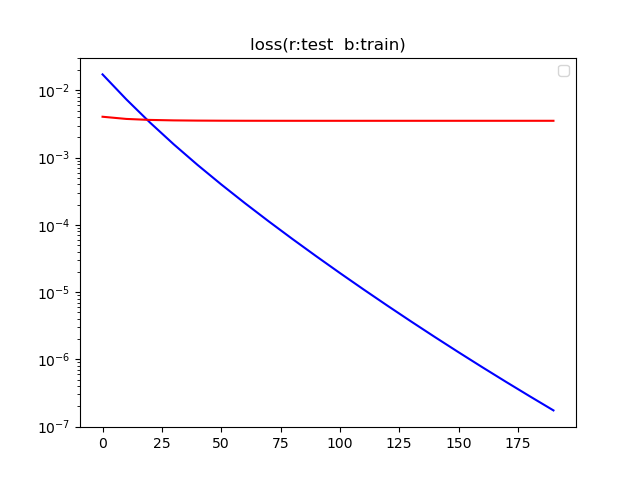

In [12]:
auto img1 = im::image("./loss_2.png");
img1  

### 使用权重衰减

In [13]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

auto w = train(train_features, test_features, train_labels, test_labels, 3.0);

Epoch 0, sum(loss_values) = 0.10043
Epoch 20, sum(loss_values) = 0.0449347
Epoch 40, sum(loss_values) = 0.0281176
Epoch 60, sum(loss_values) = 0.0215696
Epoch 80, sum(loss_values) = 0.0167711
Epoch 100, sum(loss_values) = 0.0131779
Epoch 120, sum(loss_values) = 0.0104048
Epoch 140, sum(loss_values) = 0.008218
Epoch 160, sum(loss_values) = 0.00651241
Epoch 180, sum(loss_values) = 0.00515297


In [14]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss_underfit(r:test  b:train)");
plt::legend();
plt::save("./loss_2_underfit.png"); 
plt::show();

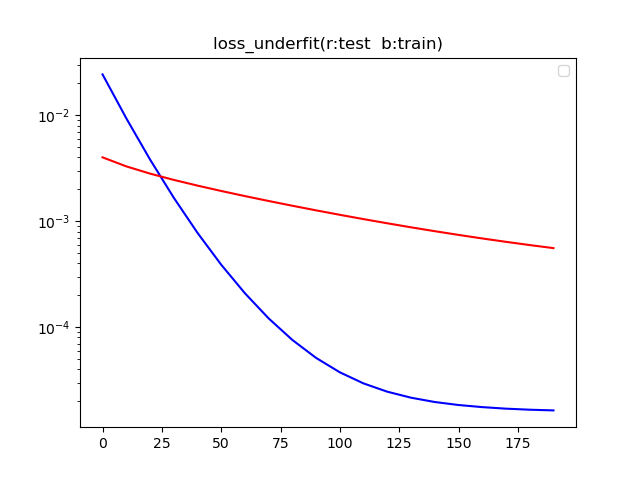

In [15]:
auto img2 = im::image("./loss_2_underfit.png");
img2

#### 因为上面已经使用了libtorch相关api，因此原教程中的简洁实现此处不再赘述，感兴趣的同学可以尝试不用api而是自己写损失函数以及优化器。